# Setup

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label

%matplotlib inline

# Load Training Data

In [2]:
# Read in cars and notcars
def load_training_data(subsets=[1, 2, 3], smallset=False):
    if smallset:
        car_images, not_car_images = [], []
        for subset in subsets:
            car_images += glob.glob('./data/vehicles_smallset/cars{}/*.jpeg'.format(subset))
            not_car_images += glob.glob('./data/non-vehicles_smallset/notcars{}/*.jpeg'.format(subset))
    else:
        car_images = glob.glob('./data/vehicles/**/*.png')
        not_car_images = glob.glob('./data/non-vehicles/**/*.png')
    return car_images, not_car_images

cars, notcars = load_training_data()

print("Number of Car samples: {}".format(len(cars)))
print("Number of Not Car samples: {}".format(len(notcars)))

Number of Car samples: 8792
Number of Not Car samples: 8968


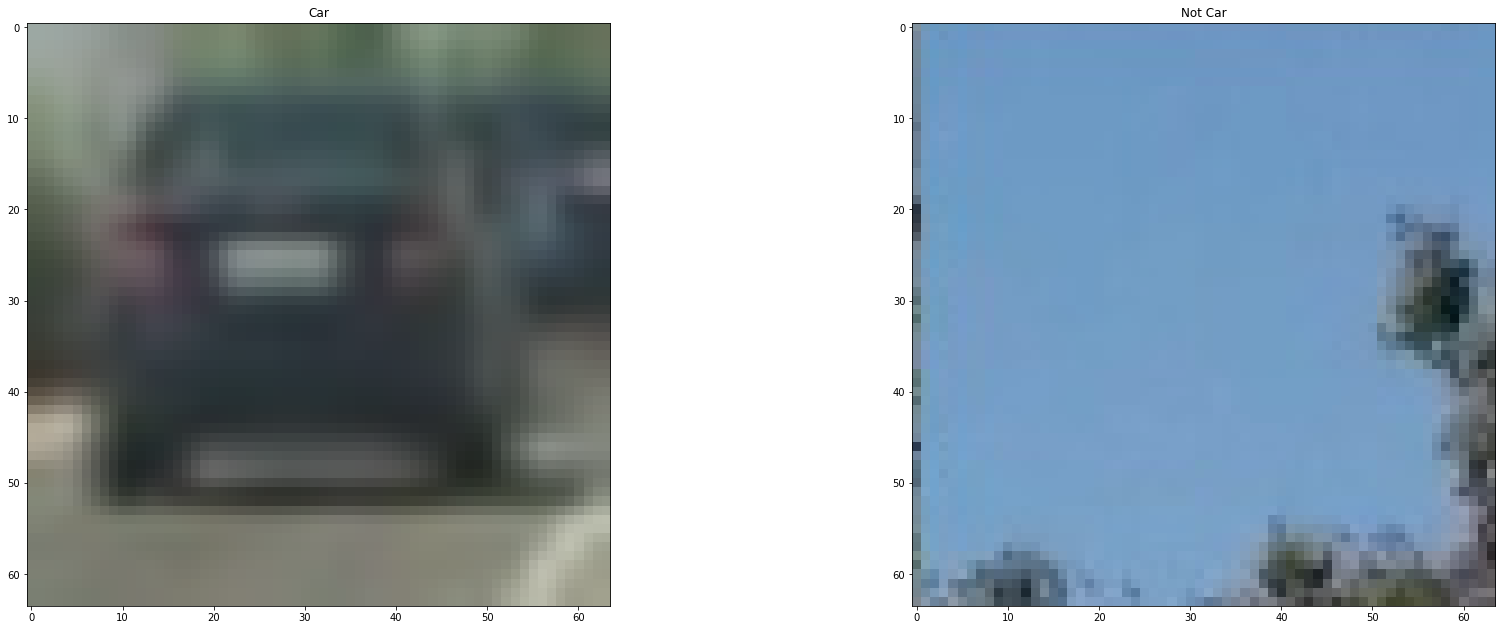

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(mpimg.imread(cars[0]))
ax1.set_title('Car')

ax2.imshow(mpimg.imread(notcars[0]))
ax2.set_title('Not Car')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Feature extraction

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


/Users/nafis/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


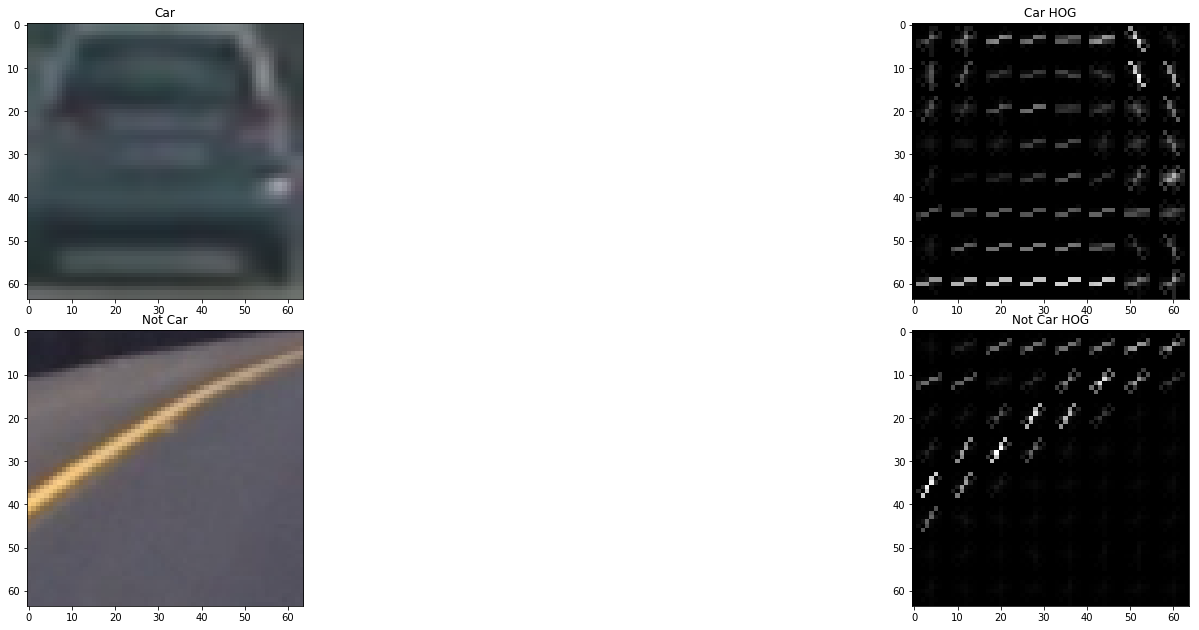

In [12]:
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

car_image = mpimg.imread(cars[10])
_, car_hog_image = get_hog_features(car_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)

notcar_image = mpimg.imread(notcars[10])
_, notcar_hog_image = get_hog_features(notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(car_image)
ax1.set_title('Car')

ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG')

ax3.imshow(notcar_image, cmap='gray')
ax3.set_title('Not Car')

ax4.imshow(notcar_hog_image, cmap='gray')
ax4.set_title('Not Car HOG')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Parameter Tuning

In [15]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# Hog Parameters
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
extraction_time = t2 - t
print('Extraction time:', round(extraction_time, 2))
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(car_features[0]))

/Users/nafis/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extraction time: 60.08
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


# Train Linear SVM Classifier

In [16]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector (car = 1, not car = 0)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
rand_state = 10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 10))


1.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9817004505


# Sliding window search

In [17]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for i, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        if color == "random":
            clr = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        else:
            clr = color
        cv2.rectangle(imcopy, bbox[0], bbox[1], clr, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return np.copy(img)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, hog_channel, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat=False, hist_feat=False, hog_feat=True, all_boxes=False):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    conv = 'RGB2' + cspace.upper()
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    found_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_feat:
                if hog_channel == "ALL":
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    assert Exception("Hog channel must be all")
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)

#             Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or all_boxes == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                found_boxes.append(box)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return found_boxes



/Users/nafis/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


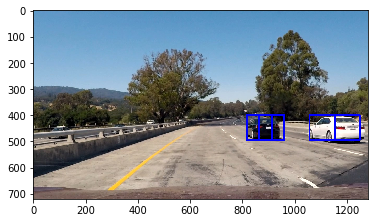

In [26]:
test_image_file = 'test1.jpg'
test_image = mpimg.imread('./test_images/' + test_image_file)

# Check the prediction time for a single sample
t = time.time()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# test_image = test_image.astype(np.float32)/255.

ystart = 400
ystop = 660
scale = 1.5

orient = 11
pix_per_cell = 16
cell_per_block = 2
color_space = 'YUV'

# out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list = find_cars(test_image, cspace=color_space, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler, 
                     hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
bound_image = draw_boxes(test_image, box_list)
    
t2 = time.time()

plt.imshow(bound_image)

mpimg.imsave('./output_images/' + test_image_file.replace('.jpg', '_basic.jpg'), bound_image,)


# Various window sizes

In [48]:

slices = [
    {'ystart': 400, 'scale': 1.0,},
    {'ystart': 416, 'scale': 1.0,},

    {'ystart': 400, 'scale': 1.5,},
    {'ystart': 432, 'scale': 1.5,},    

    {'ystart': 400, 'scale': 2.0,},    
    {'ystart': 432, 'scale': 2.0,},    

    {'ystart': 400, 'scale': 3.5,},    
    {'ystart': 464, 'scale': 3.5,},    
]


def find_cars_with_mutiple_scales(image, slices, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, all_boxes=False):
    box_list = []
    for hslice in slices:
        ystart = hslice['ystart']
        scale = hslice['scale']
        ystop =  int(min(ystart + 64*scale, 660))
        bl = find_cars(image, cspace=color_space, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler, 
                       hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins,
                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, all_boxes=all_boxes)
        box_list.append(bl)
    if all_boxes:
        return box_list
    else: # flatten
        return [item for sublist in box_list for item in sublist]



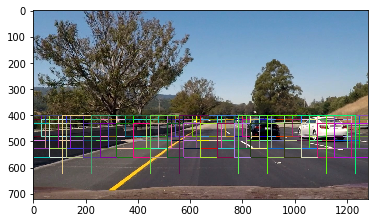

In [49]:
box_list = find_cars_with_mutiple_scales(test_image, slices, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, all_boxes=True)
bound_image = test_image
for i, bl in enumerate(box_list):
    bound_image = draw_boxes(bound_image, bl, color="random", thick=2)
plt.imshow(bound_image)
  
mpimg.imsave('./examples/sliding_windows.jpg', bound_image,)


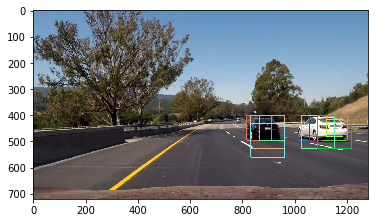

In [50]:
test_image_file = 'test6.jpg'
test_image = mpimg.imread('./test_images/' + test_image_file)


colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
X_scaler = None
hist_bins = None
spatial_size = None

box_list = find_cars_with_mutiple_scales(test_image, slices, color_space, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat)
bound_image = draw_boxes(test_image, box_list, color="random", thick=2)
plt.imshow(bound_image)

mpimg.imsave('./output_images/' + test_image_file.replace('.jpg', '_multiple.jpg'), bound_image,)

# Heatmap

In [51]:
# Read in image similar to one shown above 

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_thresholded_bounding_box(image, box_list, threshold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(image), labels)
#     draw_img = draw_boxes(np.copy(image), box_list)
    return heatmap, draw_img

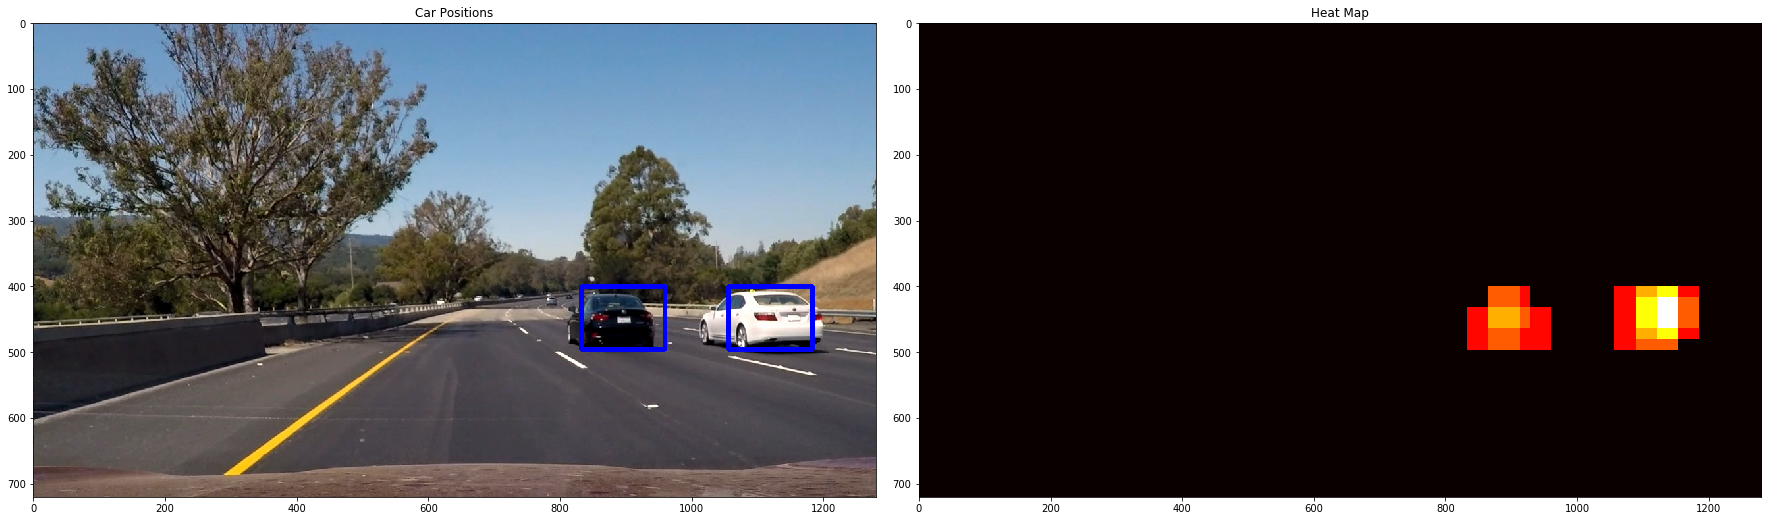

In [52]:
heatmap, draw_img = draw_thresholded_bounding_box(test_image, box_list, threshold=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(draw_img)
ax1.set_title('Car Positions')

ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Video Pipeline

In [53]:
class VehicleFrame:
    def __init__(self, queue_size=10):
        self.queue_size = queue_size
        self._box_lists = []
    
    def add_box_list(self, box_list):
        self._box_lists = [box_list] + self._box_lists
        self._box_lists = self._box_lists[:self.queue_size]
    
    @property
    def buffer_length(self):
        return len(self._box_lists)
    
    def get_new_threshold(self, threshold):
        return threshold + self.buffer_length // 2
    
    @property
    def box_list(self):
        # flatten list
        return [item for sublist in self._box_lists for item in sublist]

        

In [54]:
def process_image(img, vehicle_frame=None, threshold=2):
    box_list = find_cars_with_mutiple_scales(img, slices, color_space, svc, 
                                             X_scaler, orient, pix_per_cell, cell_per_block, 
                                             spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat)
    if vehicle_frame:
        vehicle_frame.add_box_list(box_list)
        box_list = vehicle_frame.box_list
        threshold = threshold + vehicle_frame.buffer_length // 2
    
    heatmap, output_img = draw_thresholded_bounding_box(img, box_list, threshold=threshold)
    
    return output_img

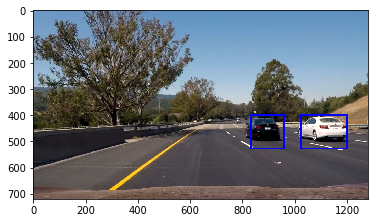

In [55]:
images = glob.glob('./test_images/*.jpg')

for image_fn in images:
    image = mpimg.imread(image_fn)
    output_image = process_image(image, vehicle_frame=None, threshold=1)
    plt.imshow(output_image)
    output_image = output_image.astype(np.float)/255.
    mpimg.imsave(image_fn.replace('test_images', 'output_images').replace('.jpg', '_full.jpg'), output_image,)

    

In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vehicle_frame = VehicleFrame()

output_video = './output_images/output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4").subclip(6, 8)
output_file = clip1.fl_image(lambda img: process_image(img, vehicle_frame=vehicle_frame)) #NOTE: this function expects color images!!
# output_file = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time output_file.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_images/output_video.mp4
[MoviePy] Writing video ./output_images/output_video.mp4


 98%|█████████▊| 50/51 [00:19<00:00,  2.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_video.mp4 

CPU times: user 16.8 s, sys: 2.27 s, total: 19.1 s
Wall time: 21.6 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))